In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.greedy_agent import GreedyAgent
from agentfil import constants
from mechafil import minting, sim

import numpyro

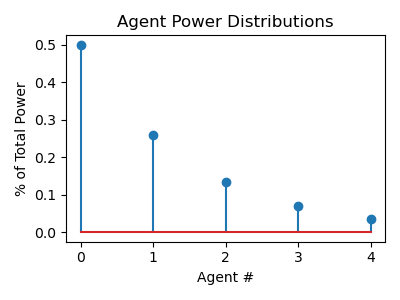

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

simulation_start_date = datetime.today().date() - timedelta(days=1)
forecast_length = 360
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 5
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.5)

# setup agent capital distributions. Proportion them in the same way as the power
starting_capital_usd = 1_000_000
capital_inflow_rate = 1000
total_capital_vec = np.arange(1,forecast_length+1) * capital_inflow_rate
total_capital_vec = total_capital_vec + starting_capital_usd
total_capital_df = pd.DataFrame({
    'date': pd.date_range(simulation_start_date, end_date, freq='D')[:-1],
    'USD': total_capital_vec  # currently unused
})
agent_accounting_df_vec = []
for ii, agent_power_pct in enumerate(agent_power_distributions):
    agent_accounting_df = total_capital_df.drop('date', axis=1)*agent_power_pct
    agent_accounting_df['date'] = total_capital_df['date']
    agent_accounting_df_vec.append(agent_accounting_df)

    
plt.figure(figsize=(4,3))

# plt.subplot(1,2,1)
plt.stem(agent_power_distributions)
plt.xlabel('Agent #')
plt.ylabel('% of Total Power')
plt.title('Agent Power Distributions')

# plt.subplot(1,2,2)
# plt.plot(total_capital_df['date'], total_capital_df['USD']/starting_capital_usd)
# plt.xticks(rotation=60)
# plt.xlabel('Date')
# plt.ylabel('\$ (Million)')

plt.tight_layout()

In [4]:
agent_types = [GreedyAgent] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
for ii, agent_accounting_df in enumerate(agent_accounting_df_vec):
    kwargs = {
        'accounting_df': agent_accounting_df,
        'forecast_num_mc': 50,
        'agent_optimism': 4,
        'random_seed': ii + random_seed_base
    }
    agent_kwargs_vec.append(kwargs)

minting_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 90,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': True,
    'keep_rbp_predictions': False
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               agent_types, agent_kwargs_vec, agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=False,
                               price_process_kwargs=price_process_kwargs,
                               minting_process_kwargs=minting_process_kwargs)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Fast forwarding power to simulation start date... 2023-01-29
Computing Scheduled Expirations from:  2023-01-29  to:  2024-01-23


In [5]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# agent plotting helper functions
def plot_agent(keys, post_process=None, agent_idxs_to_plot=None, df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if post_process is None:
        post_fn = lambda x: x
    else:
        post_fn = post_process
    
    # defaults to plotting all agents
    for ii, agent_dict in enumerate(filecoin_model.agents):
        if agent_idxs_to_plot is None or ii in agent_idxs_to_plot:
            agent_handle = agent_dict['agent']
            agent_df = getattr(agent_handle, df_name)
            l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                y = post_fn(agent_df[k])
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                y = post_fn(key_data)
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            plt.xticks(rotation=60)

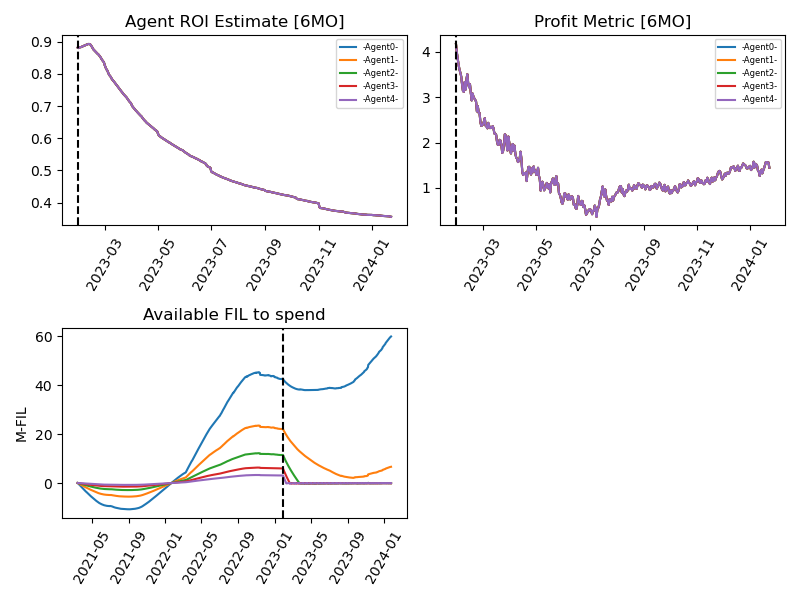

In [7]:
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plot_agent(['roi_estimate_6mo'])
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Agent ROI Estimate [6MO]')
plt.legend(fontsize=6)

plt.subplot(2,2,2)
plot_agent(['profit_duration_6mo'])
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Profit Metric [6MO]')
plt.legend(fontsize=6)

plt.subplot(2,2,3)
keys = ['reward_FIL', 
        'onboard_pledge_FIL', 
        'renew_pledge_FIL', 
        'onboard_scheduled_pledge_release_FIL', 
        'renew_scheduled_pledge_release_FIL']
def compute_available_fil_to_spend(key_data):
    available_FIL_to_spend = key_data['reward_FIL'].cumsum() \
                           - key_data['onboard_pledge_FIL'].cumsum() \
                           - key_data['renew_pledge_FIL'].cumsum() \
                           + key_data['onboard_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['renew_scheduled_pledge_release_FIL'].cumsum()
    return available_FIL_to_spend/1_000_000
plot_agent(keys, post_process=compute_available_fil_to_spend, df_name='accounting_df')
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.ylabel('M-FIL')
plt.title('Available FIL to spend')

# plt.subplot(2,2,3)
# # plt.plot(agent1_df['date'], agent1_df['USD']-agent1_df['funds_used'].cumsum())
# # plt.ylabel('$')
# # plt.title('Agent Funds Available')
# # .cumsum()/1_000_000
# plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['onboard_pledge_FIL'].cumsum()/1_000_000, label='Onboard Pledge')
# plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['renew_pledge_FIL'].cumsum()/1_000_000, label='Renew Pledge')
# plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['onboard_scheduled_pledge_release_FIL'].cumsum()/1_000_000, label='Onboard Sched. Release')
# plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['renew_scheduled_pledge_release_FIL'].cumsum()/1_000_000, label='Renew Sched. Release')
# plt.ylabel('M-FIL')
# plt.xticks(rotation=60)
# plt.axvline(simulation_start_date, linestyle='--', color='k')
# plt.legend(fontsize=6)

# plt.subplot(2,2,3)
# plt.plot(agent1_network_updates_df['date'], agent1_network_updates_df['reward_FIL']/1_000_000)
# plt.xticks(rotation=60)
# plt.axvline(simulation_start_date, linestyle='--', color='k')
# plt.ylabel('M-FIL/day')
# plt.title('Agent Block Reward Received / day')

# plt.subplot(2,2,4)
# for agent_dict in filecoin_model.agents:
#     agent = agent_dict['agent']
#     available_FIL_to_spend = agent1_network_updates_df['reward_FIL'].cumsum() \
#                            - agent1_network_updates_df['onboard_pledge_FIL'].cumsum() \
#                            - agent1_network_updates_df['renew_pledge_FIL'].cumsum() \
#                            + agent1_network_updates_df['onboard_scheduled_pledge_release_FIL'].cumsum() \
#                            + agent1_network_updates_df['renew_scheduled_pledge_release_FIL'].cumsum()
#     plt.plot(agent1_network_updates_df['date'], available_FIL_to_spend/1_000_000)
#     plt.xticks(rotation=60)
# plt.axvline(simulation_start_date, linestyle='--', color='k')
# plt.ylabel('M-FIL')
# plt.title('Available FIL to spend')

plt.tight_layout()

In [8]:
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


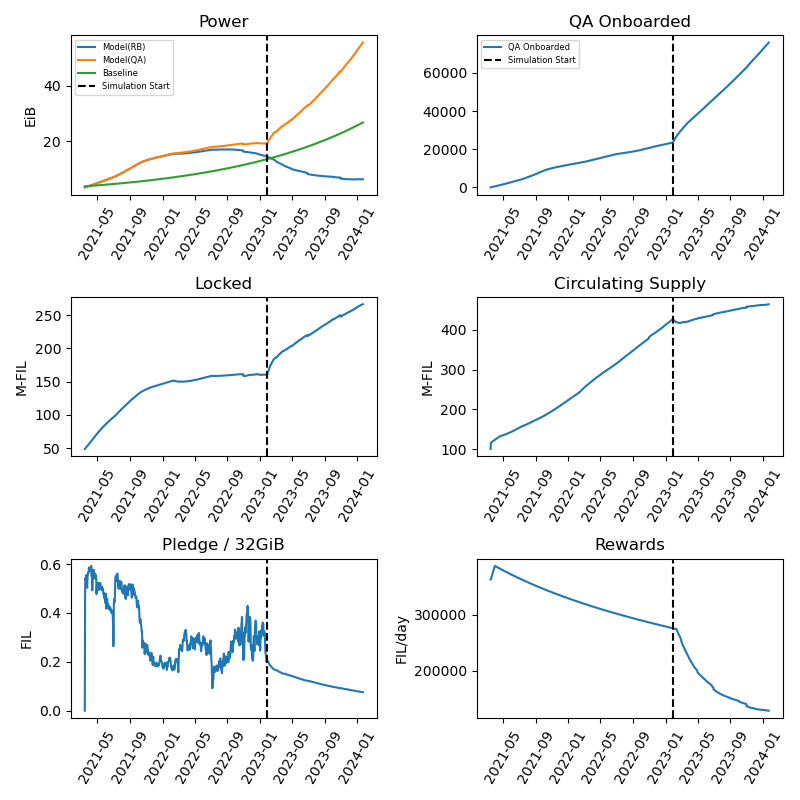

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'].cumsum(), label='QA Onboarded')
# plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='QA Renewed')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['day_pledge_per_QAP'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['day_network_reward'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')


plt.tight_layout()

plt.show()

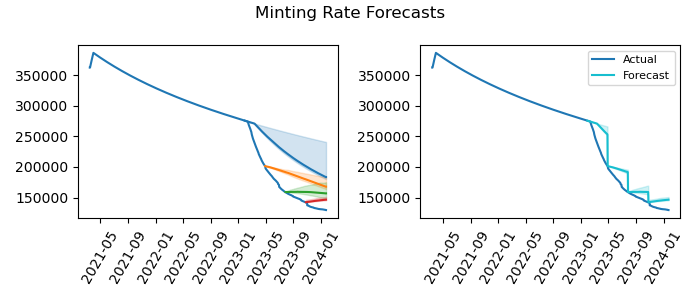

In [10]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates

plt.figure(figsize=(7,3))

colors = plt.get_cmap('tab10')

plt.subplot(1,2,1)
plt.plot(model_df['date'], model_df['day_network_reward'], label='Actual')
for ii, d in enumerate(update_dates):
    date_str = d.strftime('%Y-%m-%d')
    plt.fill_between(forecasts_df['date'], 
                     forecasts_df['day_network_reward_forecast_Q05_%s' % (date_str,)], 
                     forecasts_df['day_network_reward_forecast_Q95_%s' % (date_str,)], 
                     alpha=0.2, color=colors(ii))
    plt.plot(forecasts_df['date'], forecasts_df['day_network_reward_forecast_Q50_%s' % (date_str,)], 
             label='%s Forecast' % (date_str,), color=colors(ii))

plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.plot(model_df['date'], model_df['day_network_reward'], label='Actual')
plt.fill_between(forecasts_df['date'], 
                 forecasts_df['day_network_reward_forecast_Q05'], forecasts_df['day_network_reward_forecast_Q95'], 
                 alpha=0.2, color=colors(9))
plt.plot(forecasts_df['date'], forecasts_df['day_network_reward_forecast_Q50'], label='Forecast', color=colors(9))
plt.xticks(rotation=60)

plt.suptitle('Minting Rate Forecasts')

plt.tight_layout()
plt.legend(fontsize=8)